Converged after 1313 iterations
Solving for 41x41 grid...


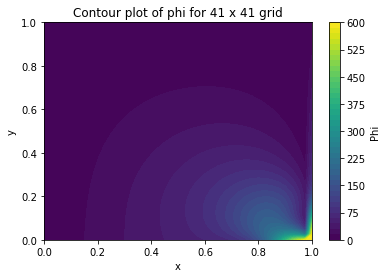

Converged after 5037 iterations
Solving for 81x81 grid...


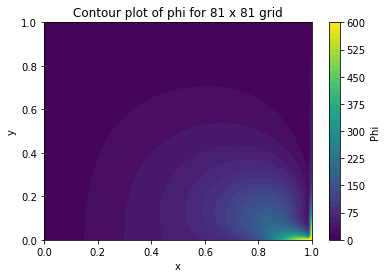

Solving for 161x161 grid...


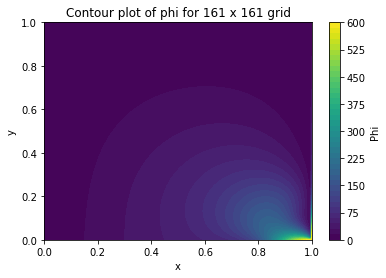

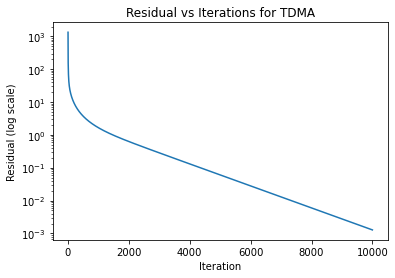

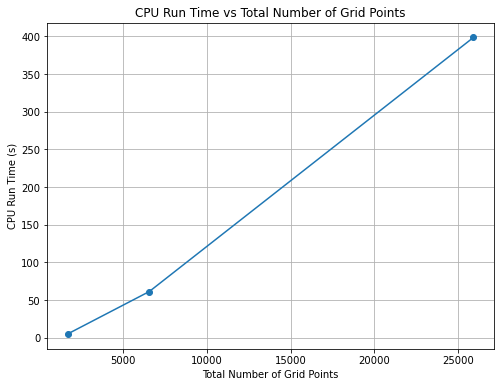

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
# Definining the physical parameters
L = 1.0
grids = [41, 81, 161]
run_times = []
for N in grids:

    dx = L / (N - 1)
    dy = L / (N - 1)
    max_iter = 10000
    tolerance = 1e-6  # for convergence
    # defining a function for keeping the Source term of the right side
    def source_term(x, y):
        return 50000 * np.exp(-50 * ((1 - x) ** 2 + y ** 2)) * (100 * ((1 - x) ** 2 + y ** 2) - 2)    
    # Defining the given boundary conditions
    def phi_bc(x, y, bound):
        if bound == 'L':
            return 500 * np.exp(-50 * (1 + y ** 2))
        elif bound == 'R':
            return 100 * (1 - y) + 500 * np.exp(-50 * y ** 2)
        elif bound == 'B':
            return 100 * x + 500 * np.exp(-50 * (1 - x) ** 2)
        elif bound == 'T':
            return 500 * np.exp(-50 * ((1 - x) ** 2 + 1))
    
    ## the Thomas Algorithm
    def tdma(a, b, c, d):
        n = len(d)
        c_new = np.zeros(n)
        d_new = np.zeros(n)

        c_new[0] = c[0] / b[0]
        d_new[0] = d[0] / b[0]

        for i in range(1, n):
            factor = b[i] - a[i] * c_new[i - 1]
            c_new[i] = c[i] / factor
            d_new[i] = (d[i] - a[i] * d_new[i - 1]) / factor

        x = np.zeros(n)
        x[-1] = d_new[-1]
        for i in range(n - 2, -1, -1):
            x[i] = d_new[i] - c_new[i] * x[i + 1]

        return x
    phi = np.zeros((N, N)) #where phi is our solution field

    # Now let us apply the boundary conditions
    x = np.linspace(0, L, N)
    y = np.linspace(0, L, N)

    for j in range(N):
        phi[j, 0] = phi_bc(0, y[j], 'L')  
        phi[j, -1] = phi_bc(1, y[j], 'R')  

    for i in range(N):
        phi[0, i] = phi_bc(x[i], 0, 'B')  
        phi[-1, i] = phi_bc(x[i], 1, 'T')
    
    start_time = time.time()
    residuals = []
    for k in range(max_iter):
        phi_old = np.copy(phi)
        for j in range(1, N-1):  
            a = np.ones(N-2) / dx**2
            b = -2 * (1/dx**2 + 1/dy**2) * np.ones(N-2)
            c = np.ones(N-2) / dx**2
            d = -source_term(x[1:-1], y[j])


            d -= (phi[j+1, 1:-1] + phi[j-1, 1:-1]) / dy**2

            phi[j, 1:-1] = tdma(a, b, c, d)

        err = np.linalg.norm(phi - phi_old)
        residuals.append(err)
        if err < tolerance:
            print(f'Converged after {k+1} iterations')
            break
    end_time = time.time()
    
    ## calculating the runtime
    print(f'Solving for {N}x{N} grid...')
    run_time = end_time - start_time
    run_times.append(run_time)
    # Plot the final solution
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, phi, 50, cmap='viridis')
    plt.colorbar(label='Phi')
    plt.title(f'Contour plot of phi for {N} x {N} grid')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
## Plot the residuals vs iterations
plt.plot(residuals)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Residual vs Iterations for TDMA')
plt.show()
# Plotting CPU run time vs number of grid points
plt.figure(figsize=(8, 6))
plt.plot([N**2 for N in grids], run_times, marker='o')
plt.xlabel('Total Number of Grid Points')
plt.ylabel('CPU Run Time (s)')
plt.title('CPU Run Time vs Total Number of Grid Points')
plt.grid(True)
plt.show() 
